# Forecasting Day-ahead Electricity Price Using LSTM-DNN model

## Introduction:

This project aims to forecast the day-ahead electricity price for a given electricity market using an LSTM-DNN hybrid model.

The problem can be modeled as a multivariate multi-step time series regression. It involves sequences of arbitrary length for which Recurrent Neural Networks are suitable. It also involves non-sequential information which are designed to be handled by the Deep Neural Network. 


## Flowchart

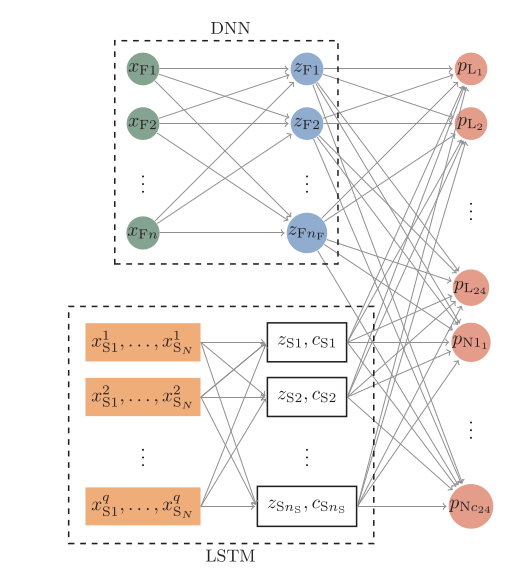

For this project, I try to predict the electricity price for the New-England electricity market for the next 24 hours, given current and past electricity price, and system load information as well as other exogenous factors.

The LSTM layer is required for the sequential data, while a DNN layer is used for non-sequential data. Sequential data includes information pertaining to the past while non-sequential information pertains to the future. Examples of the former are the past electricity prices, as well as the past load. Examples of the latter include day-ahead weather forecasts, or whether tomorrow is a holiday or not.

During training the model will use:
- sequence length : 24 * 7 = __168__ datapoints, or one week worth of hourly samples.
- input signals : __12__, these are: "__DryBulb, DewPnt, Hour, DayOfWeek, Holiday, SYSLoad, LoadPrevDayAvg, LoadPrevDay, LoadPrevWeek, PricePrevDayAvg, PricePrevDay, PricePrevWeek__"

- The outputs of both layers are to be concatenated to produce an output of __24__ electricity prices.

## Imports

These are the packages that will be needed for this project.  I have avoided upgrading to the latest version of tensorflow because of several API breaking bugs. 

In [1]:
# Ignore future warnings from using non up-to-date version of tensorflow
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Imports
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.models import Model

import pandas as pd
from datetime import datetime
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

print('Developed using Python 3.6.9')

# Print versions
print('tensorflow version: %s' % tf.__version__)
print('keras version: %s' % tf.keras.__version__)
print('pandas version: %s' % pd.__version__)
print('numpy version: %s' % np.__version__)

# Fix seed to ensure reproducibility
np.random.seed(7)

Developed using Python 3.6.9
tensorflow version: 1.14.0
keras version: 2.2.4-tf
pandas version: 0.25.1
numpy version: 1.17.2


## Load Data

The data set is imported from a csv file. The smd_hourly3.csv is a collection of observations from the years 2015 up to the current year, and I have taken the liberty of clearing out the unwanted data. The features left include the __Date__, the __Hour__, the __Real-time Locational Marginal Price__ (or simply, the electricity price), the __Dry Bulb__ and __Dew Point__ temperatures and the __System Load__. 

In [2]:
# Initial Data Import 
df = pd.read_csv("smd_hourly3.csv", names=['Date', 'Hour', 'RT_LMP', 'DryBulb', 'DewPnt', 'SYSLoad'])
# smd_hourly.csv is a collection of hourly data from 1/1/2011 to 12/31/2015 from the New England ISO

# Convert Date column from object to datetime format
df.Date = pd.to_datetime(df.Date) 

# Minus 1 from the Hour column to scale it to 0-23
df.Hour = df.Hour - 1

# Convert date time format to include the hour
df['DateString'] = df.Date.dt.strftime('%Y-%m-%d') + ' ' + df.Hour.apply(str) + ':00:00' # Reformat Date to include Hour
df['DateString'] = pd.to_datetime(df['DateString'])#.astype('datetime64') 
df['Date'] = df['DateString']
df = df.set_index('Date') # Set Date as the Index

#Check the composition of the dataset and if there are NaNs:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40896 entries, 2015-01-01 00:00:00 to 2019-08-31 23:00:00
Data columns (total 6 columns):
Hour          40896 non-null int64
RT_LMP        40896 non-null float64
DryBulb       40896 non-null int64
DewPnt        40896 non-null int64
SYSLoad       40896 non-null int64
DateString    40896 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 2.2 MB


## Input Data

The input data are loaded into a pandas dataframe. Additional features are generated and concatenated to the dataframe. Specifically, the __DayofWeek__ and the __Holiday__ features are extracted from the date column which is then set as the index for the dataframe. Lagged features such as __LoadPrevDay__, __LoadPrevWeek__, __PricePrevDay__, and __PricePrevWeek__ and SMAs which include __LoadPrevDayAvg__ and __PricePrevDayAvg__ are developed from both the electricity price and sytem load information. Day-ahead forecasts for the __DewPnt__ and __DryBulb__ are obtained via time shifts as well. After this has been done, several rows would have developed NaNs from the time shifts, and these rows would have to be dropped.

In [3]:
# Create Dataframe for Predictors
X = pd.DataFrame()
X['Date'] = df['DateString']
X = X.set_index('Date') # Set Date as the Index

# Include Dry Bulb, Dew Point, Hour and SYSLoad in the Data Frame
X = df[['DryBulb', 'DewPnt', 'Hour', 'SYSLoad']].copy()

# Shift the Weather information 24 hours into the future to obtain day-ahead "forecasts"
X['DryBulb'] = X['DryBulb'].shift(-24)
X['DewPnt'] = X['DewPnt'].shift(-24)

# Extract Day of the Week with 0 as Monday and 6 as Sunday
X['DayOfWeek'] = df['DateString'].dt.dayofweek

# Determine if a Date is a Holiday or not
dr = df['DateString']
cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
#X['Holiday'] = df['DateString'].isin(holidays)
X['Holiday'] = df['DateString'].dt.date.astype('datetime64').isin(holidays)
X.Holiday = X.Holiday.astype(int) # Convert Holiday from boolean to integer

# Shift Holiday 24 hours into the future to ID if tomorrow is a Holiday or not
X['Holiday'] = X['Holiday'].shift(-24)

# Lagged Loads
X['LoadPrevDayAvg'] = df.SYSLoad.rolling(25).mean() #SMA for the past 24 hours
X['LoadPrevDay'] = df.SYSLoad.shift(24) # Include the Past Day Load from the same Hour
X['LoadPrevWeek'] = df.SYSLoad.shift(168) # Include the Past Week Load from the same Hour

# Lagged Prices
X['PricePrevDayAvg'] = df.RT_LMP.rolling(25).mean() #SMA for the past 24 hours
X['PricePrevDay'] = df.RT_LMP.shift(24) # Include the Past Day Load from the same Hour
X['PricePrevWeek'] = df.RT_LMP.shift(168) # Include the Past Week Load from the same Hour

# Drop all the Rows with NaNs
X.dropna(inplace=True)

# Transfer SYSLoad column next to LoadPrevDavAvg for convenience in accessing later
X = X[['DryBulb', 'DewPnt', 'Hour', 'DayOfWeek', 'Holiday', 'SYSLoad', 'LoadPrevDayAvg', 'LoadPrevDay', 
      'LoadPrevWeek', 'PricePrevDayAvg', 'PricePrevDay', 'PricePrevWeek']]

# Insist on making data frame float
X = X.astype('float32')

#Check the composition of the dataset and if there are NaNs:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40704 entries, 2015-01-08 00:00:00 to 2019-08-30 23:00:00
Data columns (total 12 columns):
DryBulb            40704 non-null float32
DewPnt             40704 non-null float32
Hour               40704 non-null float32
DayOfWeek          40704 non-null float32
Holiday            40704 non-null float32
SYSLoad            40704 non-null float32
LoadPrevDayAvg     40704 non-null float32
LoadPrevDay        40704 non-null float32
LoadPrevWeek       40704 non-null float32
PricePrevDayAvg    40704 non-null float32
PricePrevDay       40704 non-null float32
PricePrevWeek      40704 non-null float32
dtypes: float32(12)
memory usage: 2.2 MB


The Line Plots of the input time series:

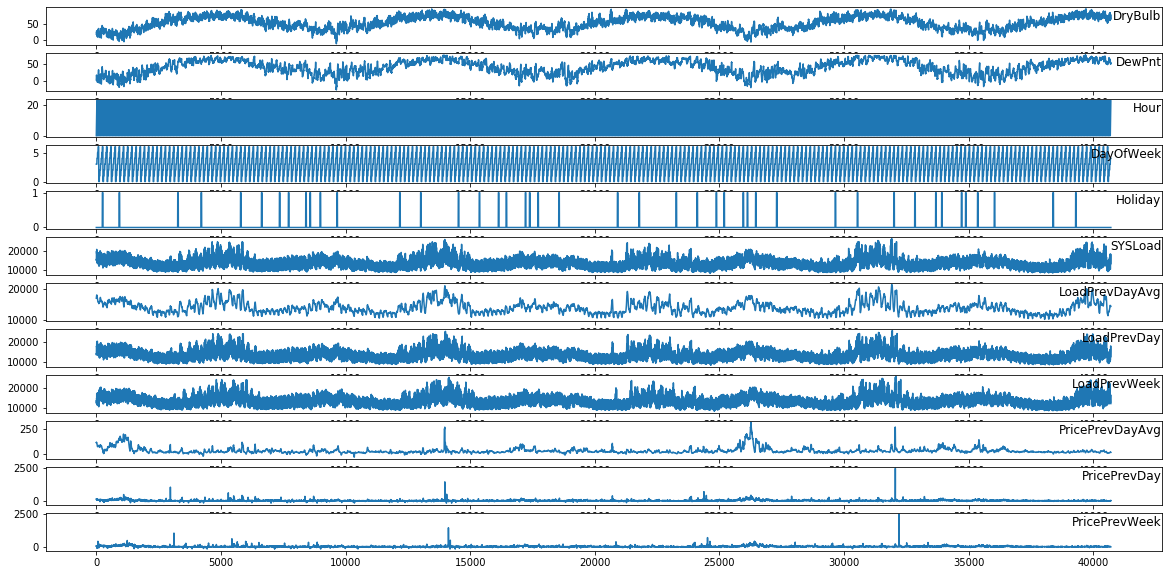

In [4]:
# This plots the Input time series
values = X.values
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
i = 1
# plot each column
plt.figure(figsize=(20,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(X.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

## Output Data

Similar to what has been done, the output is now loaded to its own pandas dataframe. Some cleanup is performed to remove the NaNs that were developed as a result of performing temporal shifts on the data as well as to maintain the shape with the input.

In [5]:
# Create Dataframe for Target
Y = pd.DataFrame()
Y['Date'] = df['DateString']
Y = Y.set_index('Date') # Set Date as the Index
#Y['ElecPrice'] = df['RT_LMP']
Y['ElecPrice1'] = df['RT_LMP'].shift(-1)
Y['ElecPrice2'] = df['RT_LMP'].shift(-2)
Y['ElecPrice3'] = df['RT_LMP'].shift(-3)
Y['ElecPrice4'] = df['RT_LMP'].shift(-4)
Y['ElecPrice5'] = df['RT_LMP'].shift(-5)
Y['ElecPrice6'] = df['RT_LMP'].shift(-6)
Y['ElecPrice7'] = df['RT_LMP'].shift(-7)
Y['ElecPrice8'] = df['RT_LMP'].shift(-8)
Y['ElecPrice9'] = df['RT_LMP'].shift(-9)
Y['ElecPrice10'] = df['RT_LMP'].shift(-10)
Y['ElecPrice11'] = df['RT_LMP'].shift(-11)
Y['ElecPrice12'] = df['RT_LMP'].shift(-12)
Y['ElecPrice13'] = df['RT_LMP'].shift(-13)
Y['ElecPrice14'] = df['RT_LMP'].shift(-14)
Y['ElecPrice15'] = df['RT_LMP'].shift(-15)
Y['ElecPrice16'] = df['RT_LMP'].shift(-16)
Y['ElecPrice17'] = df['RT_LMP'].shift(-17)
Y['ElecPrice18'] = df['RT_LMP'].shift(-18)
Y['ElecPrice19'] = df['RT_LMP'].shift(-19)
Y['ElecPrice20'] = df['RT_LMP'].shift(-20)
Y['ElecPrice21'] = df['RT_LMP'].shift(-21)
Y['ElecPrice22'] = df['RT_LMP'].shift(-22)
Y['ElecPrice23'] = df['RT_LMP'].shift(-23)
Y['ElecPrice24'] = df['RT_LMP'].shift(-24)

# Drop all the Rows with NaNs
Y.dropna(inplace=True)

# Drop the first 168 rows to keep the same shape as the input
Y = Y.loc['2015-01-08' : '2019-08-30']
    
# Insist on making data frame float
Y = Y.astype('float32')

#Check the composition of the dataset and if there are NaNs:
Y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40704 entries, 2015-01-08 00:00:00 to 2019-08-30 23:00:00
Data columns (total 24 columns):
ElecPrice1     40704 non-null float32
ElecPrice2     40704 non-null float32
ElecPrice3     40704 non-null float32
ElecPrice4     40704 non-null float32
ElecPrice5     40704 non-null float32
ElecPrice6     40704 non-null float32
ElecPrice7     40704 non-null float32
ElecPrice8     40704 non-null float32
ElecPrice9     40704 non-null float32
ElecPrice10    40704 non-null float32
ElecPrice11    40704 non-null float32
ElecPrice12    40704 non-null float32
ElecPrice13    40704 non-null float32
ElecPrice14    40704 non-null float32
ElecPrice15    40704 non-null float32
ElecPrice16    40704 non-null float32
ElecPrice17    40704 non-null float32
ElecPrice18    40704 non-null float32
ElecPrice19    40704 non-null float32
ElecPrice20    40704 non-null float32
ElecPrice21    40704 non-null float32
ElecPrice22    40704 non-null float32
ElecPrice23    40704

Line Plot of the univariate output times series:

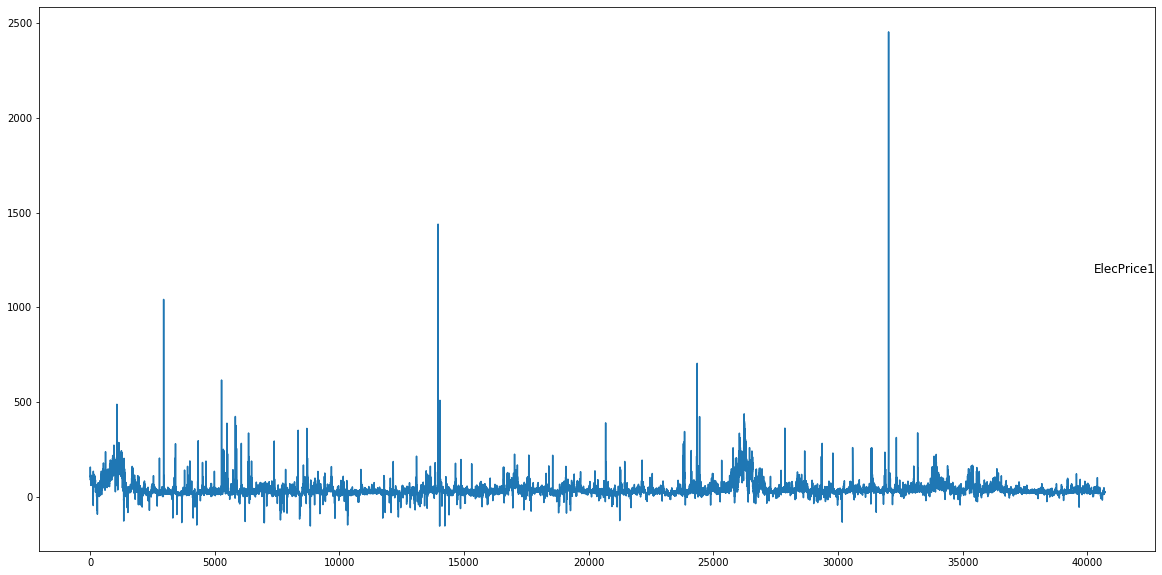

In [6]:
# This plots the Output time series
values = Y.values
groups = [0]
i = 1
# plot each column
plt.figure(figsize=(20,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(Y.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

## NumPy Arrays

The pandas dataframes are now converted to NumPy arrays for use in the neural network.


In [7]:
# Assign data frame values to arrays
x_data = X.values
y_data = Y.values

# Print the shapes of the data arrays
print(type(y_data))
print("Shape:", y_data.shape)
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (40704, 24)
<class 'numpy.ndarray'>
Shape: (40704, 12)


A quick check to see the length of samples for the train and test sets:

In [8]:
# Determine the length of the samples for the train and test set
num_total = int(len(x_data))
print("Total Number of Observations for the period of the data:", num_total)
num_train = int(len(X.loc['2015-01-08' : '2018-12-31']))
print("Total Number of Observations for the years 2015, 2016, 2017, and 2018; Training data:", num_train)
num_test = int(num_total - num_train)
print("Total Number of Observations for the year 2019; Test data:", num_test)

Total Number of Observations for the period of the data: 40704
Total Number of Observations for the years 2015, 2016, 2017, and 2018; Training data: 34896
Total Number of Observations for the year 2019; Test data: 5808


These are the input signals:

In [9]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print("Total Number of Training Input Samples", len(x_train))
print("Total Number of Testing Input Samples", len(x_test))
print("Total Number of Input Samples", len(x_train) + len(x_test))

Total Number of Training Input Samples 34896
Total Number of Testing Input Samples 5808
Total Number of Input Samples 40704


These are the output signals:

In [10]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print("Total Number of Training Output Samples", len(y_train))
print("Total Number of Testing Output Samples", len(y_test))
print("Total Number of Output Samples", len(y_train) + len(y_test))

Total Number of Training Output Samples 34896
Total Number of Testing Output Samples 5808
Total Number of Output Samples 40704


A further check to confirm the shapes of the input and output signals.

In [11]:
num_x_signals = x_data.shape[1]
print("This is the number of intput signals:", num_x_signals)
num_y_signals = y_data.shape[1]
print("This is the number of output signals:", num_y_signals)

This is the number of intput signals: 12
This is the number of output signals: 24


## Scaled Data

The dataset involves a wide range of values, including negative values.

In [12]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))
print("Min:", np.min(y_train))
print("Max:", np.max(y_train))

Min: -156.04
Max: 26024.0
Min: -156.04
Max: 2454.57


Neural networks work best using scaled values between 0 and 1 (or -1 and 1). LSTMs are particularly sensitive more so if they use the sigmoid or tanh activations so a data re-scaling is performed before feeding the data to the model. I used the MinMaxScaler function from the sci-kit learn package to transform the data to the required scaling.

In [13]:
# Re-scale the data using the MinMaxScaler
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

Check if the training data has been indeed re-scaled and look at the shape as well.

In [14]:
# Confirm that re-scaling is successful
print("x_train_scaled Min:", np.min(x_train_scaled))
print("x_train_scaled Max:", np.max(x_train_scaled))
print("y_train_scaled Min:", np.min(y_train_scaled))
print("y_train_scaled Max:", np.max(y_train_scaled))

x_train_scaled Min: 0.0
x_train_scaled Max: 1.0
y_train_scaled Min: 0.0
y_train_scaled Max: 1.0


## Data Generator

After preparing the data as 2-d re-scaled NumPy arrays, it can be observed that there are slightly less than 35,000 observations for the training set. This is far too big for my machine's GPU memory to handle or else it will crash. Thus, it still has to undergo pre-preprocessing for use in the LSTM. The LSTM layer also requires that a 3-d tensor with shape __(batch_size, timesteps, input_dim)__ as input.

In the meantime these are the array-shapes of the input and output data:

In [15]:
print("x_train_scaled Shape:", x_train_scaled.shape)
print("y_train_scaled Shape:", y_train_scaled.shape)

x_train_scaled Shape: (34896, 12)
y_train_scaled Shape: (34896, 24)


I define a function to generate batches of the training data that can be used by the model.

In [16]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.""
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
            
        x_batch_1 = x_batch[ :, :, 0:5]
        x_batch_2 = x_batch[ :, :, 5:12]
        yield ([x_batch_1, x_batch_2], y_batch)

In [17]:
batch_size = 32
sequence_length = 24 * 7

In [18]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [19]:
[x_batch_1, x_batch_2], y_batch = next(generator)

In [20]:
print(x_batch_1.shape)
print(x_batch_2.shape)
print(y_batch.shape)

(32, 168, 5)
(32, 168, 7)
(32, 168, 24)


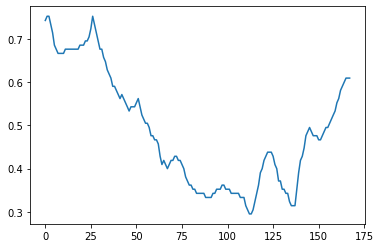

In [21]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 5 input-signals.
seq = x_batch_1[batch, :, signal]
plt.plot(seq)

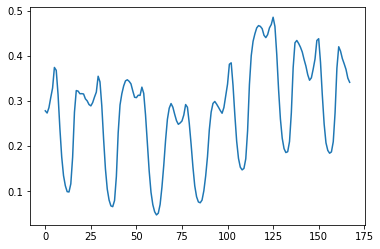

In [22]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 5 input-signals.
seq = x_batch_2[batch, :, signal]
plt.plot(seq)

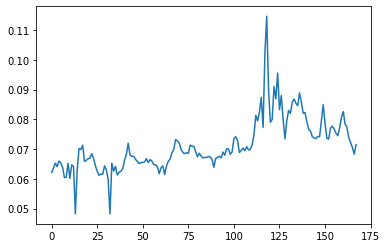

In [23]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

## Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [24]:
# Chop off x_test_scaled into two parts:
x_test1_scaled = x_test_scaled[:,0:5]
x_test2_scaled = x_test_scaled[:,5:12]

In [25]:
print("x_test_scaled Shape:", x_test_scaled.shape)
print("x_test1_scaled Shape:", x_test1_scaled.shape)
print("x_test2_scaled Shape:", x_test2_scaled.shape)
print("y_test_scaled Shape:", y_test_scaled.shape)

x_test_scaled Shape: (5808, 12)
x_test1_scaled Shape: (5808, 5)
x_test2_scaled Shape: (5808, 7)
y_test_scaled Shape: (5808, 24)


In [26]:
validation_data = ([np.expand_dims(x_test1_scaled, axis=0),
                    np.expand_dims(x_test2_scaled, axis=0)],
                   np.expand_dims(y_test_scaled, axis=0))

In [27]:
print("expanded x_test1_scaled Shape:", np.expand_dims(x_test1_scaled, axis=0).shape)
print("expanded x_test2_scaled Shape:", np.expand_dims(x_test2_scaled, axis=0).shape)
print("expanded y_test_scaled Shape:", np.expand_dims(y_test_scaled, axis=0).shape)

expanded x_test1_scaled Shape: (1, 5808, 5)
expanded x_test2_scaled Shape: (1, 5808, 7)
expanded y_test_scaled Shape: (1, 5808, 24)


## Creating the Neural Network model

In [28]:
# first input model
input_1 = Input(shape=(None, 5, ))
#input_1_expand = tf.expand_dims(input_1, axis=0)
dense_1 = Dense(units=64, input_shape=(None, 5, ))(input_1)

# second input model
input_2 = Input(shape=(None, 7, ))
#input_2_expand = tf.expand_dims(input_2, axis=0)
lstm_1 = LSTM(units=64, return_sequences=True, input_shape=(None, 5, ))(input_2)

# merge input models
merge = concatenate([dense_1, lstm_1])
output = Dense(num_y_signals, activation='sigmoid')(merge)
model = Model(inputs=[input_1, input_2], outputs=output)
# summarize layers
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 64)     384         input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 64)     18432       input_2[0]

## Loss Function

In [29]:
warmup_steps = 50

In [30]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

## Compile Model


In [31]:
optimizer = RMSprop(lr=1e-3)

In [32]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
#model.summary()

## Callback Functions

In [33]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Training the Neural Network


In [34]:
%%time
model.fit_generator(generator=generator,
                    epochs=10,
                    steps_per_epoch=30,
                    validation_data=validation_data,
                    callbacks=callbacks)


Epoch 1/10
29/30 [============================>.] - ETA: 0s - loss: 0.0422
Epoch 00001: val_loss improved from inf to 0.00098, saving model to 23_checkpoint.keras
30/30 [==============================] - 11s 361ms/step - loss: 0.0409 - val_loss: 9.7669e-04
Epoch 2/10
29/30 [============================>.] - ETA: 0s - loss: 4.4867e-04
Epoch 00002: val_loss improved from 0.00098 to 0.00010, saving model to 23_checkpoint.keras
30/30 [==============================] - 8s 253ms/step - loss: 4.4143e-04 - val_loss: 9.7566e-05
Epoch 3/10
29/30 [============================>.] - ETA: 0s - loss: 2.2936e-04
Epoch 00003: val_loss improved from 0.00010 to 0.00007, saving model to 23_checkpoint.keras

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
30/30 [==============================] - 8s 253ms/step - loss: 2.2470e-04 - val_loss: 7.4923e-05
Epoch 4/10
29/30 [============================>.] - ETA: 0s - loss: 2.8407e-04
Epoch 00004: val_loss did not improve from 0.0

The said problem list of 1 array is the validation data:

## Evaluation on Test Set

In [35]:
# Chop off x_test_scaled into two parts:
x_test1_scaled = x_test_scaled[:,0:5]
x_test2_scaled = x_test_scaled[:,5:12]

In [36]:
result = model.evaluate([np.expand_dims(x_test1_scaled, axis=0), 
                         np.expand_dims(x_test2_scaled, axis=0)], 
                        np.expand_dims(y_test_scaled, axis=0))

#result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
 #                       y=np.expand_dims(y_test_scaled, axis=0))



1/1 [==============================] - 1s 1s/sample - loss: 5.7783e-05


In [37]:
print("loss (test-set):", result)

loss (test-set): 5.7783483498496935e-05


## Generate Predictions

In [38]:
# Chop off x_train_scaled into two parts:
x_train1_scaled = x_train_scaled[:,0:5]
x_train2_scaled = x_train_scaled[:,5:12]

In [39]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = [x_train1_scaled, x_train2_scaled]
        y_true = y_train
    else:
        # Use test-data.
        x = [x_test1_scaled, x_test2_scaled]
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [40]:
plot_comparison(start_idx=100, length=5000, train=True)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([], shape=(1, 0), dtype=float64)]...